In [1]:
%pylab inline
%precision 6

Populating the interactive namespace from numpy and matplotlib


'%.6f'

In [2]:
import pandas as pd
import sklearn as skl
import sklearn
import datetime as dt

In [3]:
#you may download these functions from https://github.com/Apogentus/common
from common.serialization import pickle_load, pickle_save
from common.classes.Struct import Struct
from common.feature_transformations import get_one_hot_encoding
from common.functions import all_nums

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack

In [5]:
from sklearn.linear_model import SGDClassifier

In [6]:
pd.options.display.max_colwidth=100
np.set_printoptions(linewidth=140,edgeitems=10)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
rcParams['figure.figsize'] = (8.0, 5.0)

In [7]:
Z_train = pd.read_csv('Data/train.csv', skipinitialspace=True, sep=',', encoding='latin', index_col='PostId')

In [8]:
Z_test = pd.read_csv('Data/test.csv', skipinitialspace=True, sep=',', encoding='latin', index_col='PostId')

In [9]:
train_inds = Z_train.index.values
test_inds = Z_test.index.values

In [10]:
from sklearn.preprocessing import LabelEncoder
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(Z_train['OpenStatus'].values)

In [11]:
Z=pd.concat([Z_train,Z_test])

In [12]:
#del Z_train, Z_test

In [13]:
#len(Z), len(train_inds)+len(test_inds)

In [14]:
len(set(train_inds) & set(test_inds)), len(set(train_inds) | set(test_inds))

(0, 103140)

In [15]:
Z.rename(columns={'OpenStatus':'y'}, inplace=True)

In [16]:
Train = Z_train.copy()
Train.columns

Index(['PostCreationDate', 'OwnerUserId', 'OwnerCreationDate', 'ReputationAtPostCreation', 'OwnerUndeletedAnswerCountAtPostTime', 'Title', 'BodyMarkdown', 'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5', 'PostClosedDate', 'OpenStatus'], dtype='object')

In [17]:
Train = Train.drop('Tag1', axis=1).drop('Tag2', axis=1).drop('Tag3', axis=1).drop('Tag4', axis=1).drop('Tag5', axis=1)

In [18]:
Train = Train.drop('OpenStatus', axis=1)

In [19]:
Train = Train.drop('PostClosedDate', axis=1)

In [20]:
#Train = Train.drop('PostCreationDate', axis=1)
#Train = Train.drop('OwnerUserId', axis=1)
#Train = Train.drop('OwnerCreationDate', axis=1)
#Train = Train.drop('ReputationAtPostCreation', axis=1)
#Train = Train.drop('OwnerUndeletedAnswerCountAtPostTime', axis=1)

In [21]:
Y_train = Z.y[train_inds].values 
Y_train=Y_train.astype(str)

Y_train

array(['not a real question', 'not constructive', 'not a real question', 'off topic', 'not a real question', 'not a real question', 'open',
       'not constructive', 'off topic', 'not a real question', ..., 'not constructive', 'open', 'open', 'not a real question', 'off topic',
       'open', 'off topic', 'open', 'not a real question', 'off topic'], 
      dtype='<U19')

In [22]:
Test = Z_test.copy()

In [23]:
Test = Test.drop('Tag1', axis=1).drop('Tag2', axis=1).drop('Tag3', axis=1).drop('Tag4', axis=1).drop('Tag5', axis=1)

In [24]:
#Test = Test.drop('PostCreationDate', axis=1)
#Test = Test.drop('OwnerUserId', axis=1)
#Test = Test.drop('OwnerCreationDate', axis=1)
#Test = Test.drop('ReputationAtPostCreation', axis=1)
#Test = Test.drop('OwnerUndeletedAnswerCountAtPostTime', axis=1)
#Test = Test.drop('PostClosedDate', axis=1)


In [25]:
Train['DateDelta'] = pd.to_datetime(Train['PostCreationDate']) - pd.to_datetime(Train['OwnerCreationDate'])
Train['PostCreationDate'] = pd.to_datetime(Train['PostCreationDate'])
Train['OwnerCreationDate'] = pd.to_datetime(Train['OwnerCreationDate'])

Test['DateDelta'] = pd.to_datetime(Test['PostCreationDate']) - pd.to_datetime(Test['OwnerCreationDate'])
Test['PostCreationDate'] = pd.to_datetime(Test['PostCreationDate'])
Test['OwnerCreationDate'] = pd.to_datetime(Test['OwnerCreationDate'])

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

body_stack = np.hstack((Train['BodyMarkdown'], Test['BodyMarkdown']))
body_stack = TfidfVectorizer(analyzer='word', norm='l2').fit_transform(body_stack)

body_train = body_stack[:len(Train)]
body_test = body_stack[len(Train):]

In [27]:
title_stack = np.hstack((Train['Title'], Test['Title']))
title_stack = TfidfVectorizer(analyzer='word', norm='l2').fit_transform(title_stack)
title_train = title_stack[:len(Train)]
title_test = title_stack[len(Train):]

In [28]:
X_train = Train[['DateDelta', 'PostCreationDate', 'OwnerUserId', 'OwnerCreationDate', 'ReputationAtPostCreation', 'OwnerUndeletedAnswerCountAtPostTime']].astype(np.int64).values
X_test = Test[['DateDelta', 'PostCreationDate', 'OwnerUserId', 'OwnerCreationDate', 'ReputationAtPostCreation', 'OwnerUndeletedAnswerCountAtPostTime']].astype(np.int64).values

In [29]:
from scipy.sparse import hstack
from scipy.sparse import vstack
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False).fit(vstack((X_train, X_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [30]:
vstack((X_train, X_test)).shape

(103140, 6)

In [31]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [32]:
X_train = hstack([X_train, title_train, body_train])

X_test = hstack([X_test, title_test, body_test])

In [33]:
clf = SGDClassifier(loss='modified_huber', alpha=0.00001, max_iter=50)

In [34]:
from sklearn.model_selection import train_test_split
X, X_val, Y, Y_val = train_test_split(X_train, y, train_size=0.85, random_state=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [40]:
X_train.shape

(63462, 334369)

In [39]:
X_test.shape

(39678, 334369)

In [35]:
#%%time

#clf.fit(X, Y)

In [36]:
#clf.score(X_val, Y_val)

In [52]:
#Y_hat = clf.predict(X_test)
#Y_hat = lab_enc.inverse_transform(Y_hat)

# Grid and Randomized Search for finding best  parameters

In [ ]:
(0.58043824848911796, {'penalty': 'none', 'max_iter': 100, 'loss': 'perceptron', 'alpha': 0.005}) #0.52396

In [ ]:
(penalty': 'l1', 'max_iter': 50, 'loss': 'perceptron', 'alpha': 1e-05})

In [41]:
clf = SGDClassifier(penalty='l1', loss='perceptron', alpha=1e-05, n_jobs=10, max_iter=50)

In [86]:
clf2 = SGDClassifier(loss='modified_huber', alpha=0.00001, n_jobs=10, max_iter=100, penalty='l1')

In [87]:
clf2.fit(X,Y)

SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', max_iter=100,
       n_iter=None, n_jobs=10, penalty='l1', power_t=0.5,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [88]:
%%time 
scores2 = cross_val_score(clf2, X, Y, cv = 10)
np.mean(scores2)

CPU times: user 11min 45s, sys: 51.4 ms, total: 11min 45s
Wall time: 2min 38s


In [89]:
np.mean(scores2)

0.572576

In [53]:
%%time

clf.fit(X, Y)

CPU times: user 1min 51s, sys: 110 ms, total: 1min 51s
Wall time: 34.6 s


SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='squared_hinge', max_iter=100,
       n_iter=None, n_jobs=10, penalty='l1', power_t=0.5,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [42]:
%%time 
scores = cross_val_score(clf, X, Y, cv = 10)

Wall time: 1min 44s


In [44]:
np.mean(scores)

0.576767

In [43]:
clf.fit(X,Y)

SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='perceptron', max_iter=50,
       n_iter=None, n_jobs=10, penalty='l1', power_t=0.5,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [118]:
from sklearn.model_selection import GridSearchCV

param = {
    'max_iter': [25, 50, 100],
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 
                  'perceptron'],
    'alpha': [0.001, 0.0001, 0.00001, 0.005, 0.0075, 0.0025],
    'penalty' : ['l2', 'l1', 'elasticnet', 'none']
}

grid_search = GridSearchCV(clf, param, n_jobs=10)

In [56]:
from sklearn.externals import joblib

joblib.dump(clf, 'model1.pkl') 

['model1.pkl']

In [ ]:
%%time

grid_search.fit(X, Y)

In [ ]:
m = (grid_search.best_score_, grid_search.best_params_)
with open('res.log', 'a') as f:
    f.write(str(m))
    f.write("\n") 
m

In [61]:
grid_search.predict(X_test)

array([2, 0, 0, 0, 0, 2, 0, 0, 2, 1, ..., 3, 1, 0, 3, 3, 1, 0, 0, 1, 0])

In [121]:
from sklearn.model_selection import RandomizedSearchCV

clf_rand = RandomizedSearchCV(SGDClassifier(), param, n_jobs=10, n_iter=20)

/usr/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [124]:
%%time

clf_rand.fit(X, Y)

CPU times: user 37.6 s, sys: 414 ms, total: 38 s
Wall time: 3min 17s


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=10,
          param_distributions={'max_iter': [25, 50, 100], 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'alpha': [0.001, 0.0001, 1e-05, 0.005, 0.0075, 0.0025], 'penalty': ['l2', 'l1', 'elasticnet', 'none']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [125]:
m = (clf_rand.best_score_, clf_rand.best_params_)
with open('res.log', 'a') as f:
    f.write(str(m)) 
    f.write("\n") 
m

(0.580438,
 {'alpha': 0.005000, 'loss': 'perceptron', 'max_iter': 100, 'penalty': 'none'})

In [ ]:
'alpha': 0.0025, 'loss': 'squared_hinge', 'max_iter': 100, 'penalty': 'elasticnet'}

In [135]:
clf = SGDClassifier(max_iter=100, loss='squared_hinge', alpha=0.0025, penalty='elasticnet')

In [ ]:
scores = cross_val_score(clf, X, Y, cv = 5)
np.mean(scores)

In [ ]:
Y_hat= clf_rand.predict(X_test)
Y_hat = lab_enc.inverse_transform(Y_hat)

In [62]:
Y_hat= grid_search.predict(X_test)
Y_hat = lab_enc.inverse_transform(Y_hat)

In [45]:
Y_hat= clf.predict(X_test)
Y_hat = lab_enc.inverse_transform(Y_hat)

# Visualization

In [81]:
from common.visualize.colors import COLORS
from common.visualize.distributions import *
from common.functions import all_nums, vec, row
from common.visualize.method import plot_predictions_2D

In [77]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(random_state=0)

In [78]:
tsvd.fit(X)
X_tsvd = tsvd.transform(X)

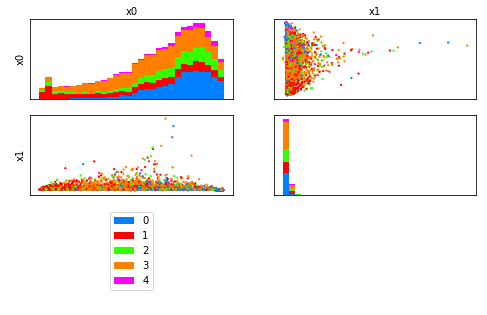

In [85]:
cross_distributions_classification(X_tsvd, Y)

# Submission

In [47]:
S = pd.DataFrame(Y_hat, columns=['OpenStatus'], index = Z.loc[test_inds].index)

In [48]:
S.head()

,OpenStatus
PostId,
2,off topic
4,not a real question
8,not a real question
10,not a real question
11,not a real question


In [49]:
S.to_csv('Data/after6.csv')  # accuracy>0.49 on test

Hints for further improvement:
 * tune parameters of baseline model
 * use information about title
 * use information about tags
 * use information about user reputation, duration on StackOverflow
 * generate your own features
 * did moderation policy change in 2012? adapt model scores to anticipate change in policy.